# Implementing the TabTransformer as a Model in TF

In this notebook, I will use notebooks I created to implement a TabTransformer model by subclassing keras.Model

In [20]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *

#from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
atm_df = get_atm(df, 26637)
atm_df = atm_df[:-135]
atm_df = clean_data(atm_df, drop_zeros=True)
atm_feature_set = get_feature_sets(atm_df, ['CashIn', 'CashOut'])

## Defining Transformer Layer

In [22]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # parametreleri
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        # batch-layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Defining TabTransformer Model

In [23]:
class TabTransformer(tf.keras.Model):

    def __init__(self, 
            categories,
            num_continuous,
            dim,
            dim_out,
            depth,
            heads,
            attn_dropout,
            ff_dropout,
            mlp_hidden):
        """TabTrasformer model constructor

        Args:
            categories (:obj:`list`): list of integers denoting the number of 
                classes for a categorical feature.
            num_continuous (int): number of categorical features
            dim (int): dimension of each embedding layer output, also transformer dimension
            dim_out (int): output dimension of the model
            depth (int): number of transformers to stack
            heads (int): number of attention heads
            attn_dropout (float): dropout to use in attention layer of transformers
            ff_dropout (float): dropout to use in feed-forward layer of transformers
            mlp_hidden (:obj:`list`): list of tuples, indicating the size of the mlp layers and
                their activation functions
        """
        super(TabTransformer, self).__init__()

        # --> continuous inputs
        self.continuous_normalization = layers.LayerNormalization()

        # --> categorical inputs

        # embedding
        self.embedding_layers = []
        for number_of_classes in categories:
            self.embedding_layers.append(layers.Embedding(input_dim = number_of_classes, output_dim = dim))

        # concatenation
        self.embedded_concatenation = layers.Concatenate(axis=1)

        # adding transformers
        self.transformers = []
        for _ in range(depth):
            self.transformers.append(TransformerBlock(dim, heads, dim))
        self.flatten_transformer_output = layers.Flatten()

        # --> MLP
        self.pre_mlp_concatenation = layers.Concatenate()

        # mlp layers
        self.mlp_layers = []
        for size, activation in mlp_hidden:
            self.mlp_layers.append(layers.Dense(size, activation=activation))

        self.output_layer = layers.Dense(dim_out)

    def call(self, inputs):
        continuous_inputs  = inputs[0]
        categorical_inputs = inputs[1:]
        
        # --> continuous
        continuous_inputs = self.continuous_normalization(continuous_inputs)

        # --> categorical
        embedding_outputs = []
        for categorical_input, embedding_layer in zip(categorical_inputs, self.embedding_layers):
            embedding_outputs.append(embedding_layer(categorical_input))
        categorical_inputs = self.embedded_concatenation(embedding_outputs)

        for transformer in self.transformers:
            categorical_inputs = transformer(categorical_inputs)
        contextual_embedding = self.flatten_transformer_output(categorical_inputs)

        # --> MLP
        mlp_input = self.pre_mlp_concatenation([continuous_inputs, contextual_embedding])
        for mlp_layer in self.mlp_layers:
            mlp_input = mlp_layer(mlp_input)

        return self.output_layer(mlp_input)

## Helper Method for Aranging Input

In [24]:
def get_input_sets(feature_set, groups):
    """
    Generate input sets from a feature set

    Args:
        feature_set(:obj:`DataFrame`): Pandas dataframe to generate input sets from.
        groups(:obj:`list`): List of lists with each member list denoting a group of features.

    Returns:
        List of datasets corresponding to the groups
    """
    result = []
    for group in groups:
        result.append(feature_set[group])
    return result
    

In [25]:
atm_feature_set.columns

Index(['CashIn', 'CashOut', 'CashIn_average_7', 'CashIn_average_30',
       'CashOut_average_7', 'CashOut_average_30', 'CashIn_trend_7',
       'CashOut_trend_7', 'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29', 'CashOut_t-30',
       'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33', 'CashOut_t-34',
       'CashOut_t-35', '

In [26]:
categorical_features = ['Day_of_the_Week_Index', 'Day_of_the_Month_Index',
       'Week_of_the_Year_Index', 'Is_Weekday', 'Special_Dates_Index',
       'is_cocuk_bayrami', 'is_isci_bayrami', 'is_spor_bayrami',
       'is_zafer_bayrami', 'is_cumhuriyet_bayrami']
continuous_features   = ['CashIn_average_7', 'CashIn_average_30',
       'CashOut_average_7', 'CashOut_average_30', 'CashIn_trend_7',
       'CashOut_trend_7', 'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29', 'CashOut_t-30',
       'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33', 'CashOut_t-34',
       'CashOut_t-35', 'CashOut_t-36', 'CashOut_t-37', 'CashOut_t-38',
       'CashOut_t-39', 'CashOut_t-40']

groups = [continuous_features]
groups.extend(categorical_features)

## Declaring the Model

In [27]:
tabTransforer = TabTransformer(
    categories = [len(atm_feature_set[categorical].unique()) for categorical in categorical_features],
    num_continuous = len(continuous_features),
    dim = 16,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.1,
    ff_dropout = 0.1,
    mlp_hidden = [(64, 'relu'), (16, 'relu')]
)

## Testing the Model

In [28]:
def train_test_split(X, y, split=0.2):
    cut = int(X.shape[0] * split)
    return X[:-cut], X[-cut:], y[:-cut], y[-cut:]

In [29]:
TARGET = 'CashIn'
X_train, X_test, y_train, y_test = train_test_split(atm_feature_set[atm_feature_set.columns[2:]], atm_feature_set[TARGET])

train_inputs = get_input_sets(X_train, groups)
test_inputs  = get_input_sets(X_test, groups)

In [30]:
tabTransforer.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.005),
    loss='mape')

In [31]:
history = tabTransforer.fit(train_inputs, 
            y_train,
            batch_size=32,
            epochs=100,
            validation_data=(test_inputs, y_test),
            verbose = 0)

In [32]:
def plot_history(history):
    plt.figure(figsize=(10,4))
    for key in history.history:
        plt.plot(history.history[key][:], label = key)
    plt.legend()
    plt.show()

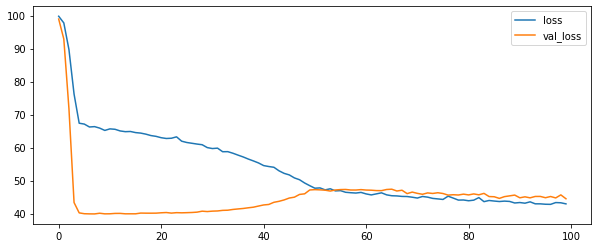

In [33]:
plot_history(history)

In [34]:
"min_loss: %.4f, min_val_loss: %.4f" % (min(history.history['loss']), min(history.history['val_loss']))

'min_loss: 42.7976, min_val_loss: 39.8996'

In [35]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [36]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_pred = pd.Series(model.predict(X).reshape(-1), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)

In [37]:
draw_model_error(tabTransforer, get_input_sets(atm_feature_set[atm_feature_set.columns[2:]], groups), atm_feature_set[TARGET], split_from=X_train.index[-1])